In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import fourierModel as fm
from copy import copy as dup
from scipy.integrate import odeint
from matplotlib import animation
from IPython.display import HTML

import diffusionstuff7 as ds

In [2]:
# Graphics parameters
%matplotlib inline
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# Number of iterations to calculate Nliq from Ntot
niter = 1

# Message
print("Starting a new system")
nx = 512 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Nice = np.ones(boxpoints) # begin with one layer of ice
#Adding noise to test stability of system (-Max, 6/27/2020)
#Nice += np.random.normal(0,0.01,nx)

Fliq = fm.getNliq_array(Nice,Nstar,Nbar,niter) # initialize quasi-liquid layer    

Starting a new system


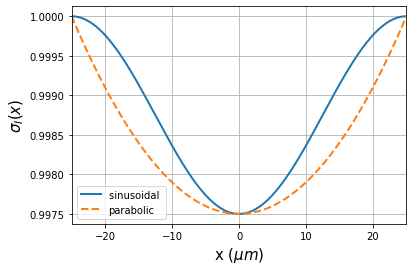

In [4]:
# Lay out the system
Ntot = Fliq + Nice     # add ice layers and quasi liquid layer to get total
nmid = int(nx/2)       # locate index of midpoint
nquart = int(nx/4)     # index of quarter point
xmid = max(x)/2        # x location of midpoint
xmax = x[nx-1]         # maximum x value
Nice_start = Nice[0]   # initial ice layer

# I'm not sure what this one does 
#NOTE: It does not do anything (unused) -Max
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Old comment: Should be close to .75; not used if D=const   

# Just conversions
nmpermonolayer = 0.3 # nanometers per layer
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6) # not sure what this is

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond
#D = 0

# Time steps
dtmaxtimefactor = 10 # duplicate line of code overwritten in next line?
dtmaxtimefactor = 50 # unsure what this is
dtmax = deltaX**2/D  # I think this is the step size to guarantee stability (no longer needed in Fourier?)
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19 # I don't know exactly what this is
sigmastepmax = 0.20 # Value at edges(?), Must be bigger than sigma0 to get growth
center_reduction = 0.25 # How much lower the middle is, in percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2 # probably no longer needed in Fourier version

# Gets the function sigma(x) - higher deposition at the edges
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') # sinusoidal shape
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic') # parabolic shape
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [5]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True # unsure if needed in Fourier model

# Set up a maximum number of iterations or layers
# I think for my vision of the Fourier approach, we won't need this
uselayers = True

# 1D run 
if uselayers:
    layermax_1D = 200
else:
    countermax_1D = 15000

In [6]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec') # diffusion
print('deltaT_max (Diffusion time)', dtmax) # diffusion time
print('deltaT =', deltaT) # timestep(?)
print('deprate =', deprate, 'monolayers/us') # deposition rate
print('nmid', nmid) # midpoint
print('N*', Nstar) # N^*
print('N*x2pi', Nstar*2*np.pi) # 2 pi N^*
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar) # N average (what is N?) and deviation
print('deltaX', deltaX) # spatial step size
print('sigma_0 =', sigma0) # supersaturation default
print('sigmastepmax =', sigmastepmax) # deviation from default
print('center reduction', center_reduction, '%') # reduction of supersaturation in the center
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec') # max growth rate (edge)
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec') # min growth rate (center)
print('nu_kin =', nu_kin, 'um/sec') # nu-kinetic

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 47.87052745661972
deltaT = 0.9574105491323944
deprate = 0.16333333333333333 monolayers/us
nmid 256
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.09784735812133072
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [7]:
L = xmax/2; print(L) # half of spatial grid, micrometers
c_r = center_reduction / 100; print(c_r) # percent reduction in supersaturation in center, dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # deposition rate, monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # sigma at edge, dimensionless
print(D) # diffusion rate, micrometers^2/microsecond
M = np.array([.0027, .0025]) # not sure what this is
B = np.array([2.9, 1.59]) # not sure what this is
beta = np.array([0.65, 0.65]) # not sure what this is
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D # not sure what this is
NSS = M*xfactor + B # not sure what this is, but it's clearly something different for sine vs parabolic supersaturation profile
print('Nss predicted')
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

25.0
0.0025
0.16333333333333333
0.2
0.0002
Nss predicted
sinusoid: 8.510216387742963
paraboloic: 6.784644803465706


In [8]:
# This is the 1-d run

# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([niter,nx])

# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Time steps (these are dlecared in 0d model, instead of here, in continuum_model.ipynb)
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0] # initial ice layer
Nice0 = Nice[0] # current ice layer
Ntot0_start = Ntot[0] # initial total layers
Ntot0 = Ntot[0] # total layers
updatingFliq = True # not sure what this does
counter = 0 # current timestep
lastlayer = 0 # last layer of liquid
lastdiff = 0 # maximum difference between edge and center

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(float_params,int_params,sigmastep), rtol=1e-12) 
    
    # reshape output into total and liquid
    ylast = np.reshape(y[1],(2,nx))
    
    # increment timestep
    tlast += deltaT
    
    # increment timestep counter
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = fm.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT
    
    # Save into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    Fliqkeep.append(Fliq)
    tkeep.append(ttot)
    
    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 7.039535049324641e-06 7.039535049324641e-06
165 1 0.009876108174743603 0.009869068639694278
330 2 0.05977132779646821 0.04989521962172461
495 3 0.21866405816462864 0.15889273036816043
660 4 0.41376373775249053 0.1950996795878619
825 5 0.554116636272898 0.14035289852040744
991 6 0.6294147048889087 0.07529806861601074
1156 7 0.6929318047737834 0.06351709988487464
1321 8 0.7361390081080614 0.04320720333427808
1486 9 0.7671165185192095 0.030977510411148046
1651 10 0.7903721211501313 0.023255602630921857
1817 11 0.806456450134629 0.01608432898449763
1982 12 0.8217491055926001 0.015292655457971094
2147 13 0.8343746744987328 0.012625568906132756
2312 14 0.8450649551842364 0.010690280685503595
2477 15 0.8543197440734573 0.009254788889220933
2643 16 0.8622433910589002 0.0079236469854429
2808 17 0.8697649123468807 0.007521521287980448
2973 18 0.876623550058973 0.006858637712092275
3138 19 0.882976882968233 0.00635333290925999
3304 20 0.8890931016087045 0.006116218640471516
3469 21 0.89485668

28034 169 3.9705261396638036 0.004881916341702208
28201 170 3.97552664013665 0.00500050047284617
28368 171 3.9805817966061454 0.005055156469495614
28535 172 3.985580350937397 0.004998554331251626
28702 173 3.9903537637275974 0.004773412790200382
28869 174 3.9947045239559316 0.0043507602283341384
29036 175 3.9985909106200666 0.0038863866641349887
29203 176 4.002835439259968 0.004244528639901546
29371 177 4.008391742801649 0.005556303541681018
29538 178 4.024710494418031 0.016318751616381633
29705 179 4.0681995205612225 0.04348902614319172
29872 180 4.15388558418428 0.08568606362305786
30039 181 4.269225209325725 0.11533962514144491
30206 182 4.383549090130856 0.11432388080513078
30374 183 4.448491107375673 0.06494201724481741
30541 184 4.530012213703571 0.081521106327898
30708 185 4.59252236678833 0.06251015308475871
30875 186 4.640480435026944 0.04795806823861426
31043 187 4.666532988441986 0.026052553415041757
31210 188 4.698558708779956 0.03202572033796969
31377 189 4.724193977970003

Height of Ice 195.16994604337884
1-D growth, corner 198.4857519395598
1-D growth, center 194.30478324263038
1-D Modeled growth rate, corner, um/s 1.8816615023936984
1-D Modeled growth rate, corner, ml/us 0.0062722050079789945
1-D Modeled growth rate, center, um/s 1.8420255700265185
1-D Modeled alpha, corner 0.1920211891077133
1-D Modeled alpha, center 0.18843287323886976
Difference, % -1.8687082844959815
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904


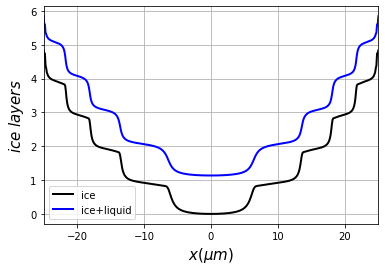

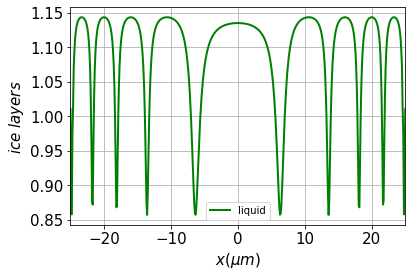

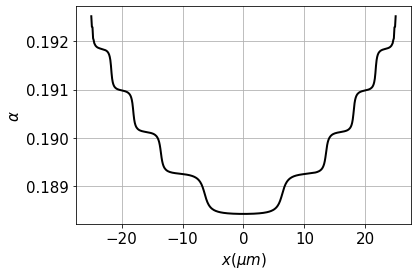

In [9]:
# Growth statistics
minpoint = min(Nice)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entire = Ntot-Ntotkeep[0]

# growth at corner and in center
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])

# growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')


In [9]:
import scipy as sp

def fftnorm(u_full):
    """Computes normalized FFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete FFT is to be computed

    Returns
    -------
    normalizedFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """

    normalizedFFT = np.fft.rfft(u_full,norm = "forward")
    return normalizedFFT

def ifftnorm(u_full):
    """Computes normalized IFFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete IFFT is to be computed

    Returns
    -------
    normalizedIFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """
    

    normalizedIFFT = np.fft.irfft(u_full, norm = "forward")
    return normalizedIFFT

def convolution(nT,depsurf,Nstar):
    """Computes Fourier transform of the nonlinear term in the QLL PDE
    
    2 pi N^* sigmaM vKin cos(Ntot)
    
    Computed in real space and then converted back
    to Fourier space.
    
    Parameters
    ----------
    nT : 1D Numpy Array (N,)
        Total water layers
        
    nu_kin : TBD
        TBD
        
    sigmastep : TBD
        TBD
        
    Nstar : TBD
        TBD

    Returns
    -------
    convo : 1D Numpy Array (N,)
        Fourier transform of the nonlinear term
    """

    
    # compute double sum in real space, then apply scalar multiplier
    convo = 2 * np.pi * Nstar * fftnorm(depsurf * np.cos(2*np.pi*ifftnorm(nT)))
    return convo

def nTotRHS(nQLL,depsurf,k,D):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dnk/dt = -k^2 D nkQLL + 2 pi FFT(sigma_m) nu_kin
    
    
    Parameters
    ----------
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient

    Returns
    -------
    dnTot : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """


    dnTot = -k**2 * D * nQLL + fftnorm(depsurf)
    
    return dnTot

def nQLLRHS(nTot,nQLL,depsurf,k,D,Nstar):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dn0/dt = 2 * pi * sigma_m * nu_kin
    dnk/dt = -k^2 D nkQLL
    
    
    Parameters
    ----------
    nTot : 1D Numpy Array (N,)
        Positive modes of state vector for total layers
    
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient
        
    Nstar : float
        TBD

    Returns
    -------
    dnQLL : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """
    
    convo = convolution(nTot,depsurf,Nstar)
    #print(np.max(np.abs(convo)))

    dnQLL = -k**2 * D * nQLL + convo
    
    return dnQLL


def RHS(t,n,params):
    """
    Computes the RHS for a full KdV or ROM simulation. For use in solver.
    
    Parameters
    ----------
    t : float
        Current time
        
    n : Numpy array (2N,)
        Current state vector of positive modes (total first, then QLL)
              
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    RHS : 1D Numpy array (2N,)
          Derivative of each positive mode in state vector
    """
    
    # extract parameters from dictionary
    N = params['N']
    nu_kin = params['nu_kin']
    k = params['k']
    D = params['D']
    Nstar = params['Nstar']
    Nbar = params['Nbar']
    sigma0 = params['sigma0']
    sigmastep = params['sigmastep']
    deprate = params['deprate']
    
    nTot = n[0:N]
    nQLL = n[N:]
    

    delta = (ifftnorm(nQLL) - (Nbar - Nstar))/(2*Nstar)
    sigD = (sigmastep - delta*sigma0)/(1+delta*sigma0)
    depsurf = deprate*sigD
    
    
    dnT = nTotRHS(nQLL,depsurf,k,D)
    dnQ = nQLLRHS(nTot,nQLL,depsurf,k,D,Nstar)
    
    RHS = np.concatenate((dnT,dnQ))

    return RHS

def runSim(params):
    """
    Runs a simulation of the ice continuum in Fourier space
    
    Parameters
    ----------
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    uSim : ODE solver output
           Output solution from sp.integrate.solve_ivp (includes state vector at all timesteps, time vector, etc.)
    """
    
    # unpack parameters from dictionary
    N = params['N']
    ICNT = params['ICNT']
    ICNQLL = params['ICNQLL']
    endtime = params['endtime']
    timesteps = params['timesteps']
    
    nTotIC = fftnorm(ICNT)[0:N]
    nQLLIC = fftnorm(ICNQLL)[0:N]
    
    n = np.concatenate((nTotIC,nQLLIC))
    
    # define RHS in form appropriate for solve_ivp
    def myRHS(t,y):
        out = RHS(t,y,params)
        return out
    
    # solve the IVP
    uSim = sp.integrate.solve_ivp(fun = myRHS, t_span = [0,endtime], y0 = n, t_eval = timesteps)
    return uSim

def makeReal(fourierSol): 
    
    N = int(fourierSol.shape[0]/2)
    timesteps = fourierSol.shape[1]
    
    NTot = np.zeros((timesteps,2*N-2))
    NQLL = np.zeros((timesteps,2*N-2))
    
    for i in range(timesteps):
        NTot[i,:] = ifftnorm(fourierSol[0:N,i])
        NQLL[i,:] = ifftnorm(fourierSol[N:,i])
        
    return [NTot, NQLL]

In [10]:
N = 64
xRed = np.arange(0,50,50/(2*N-2))
sigmastepRed = fm.getsigmastep(xRed,xmax,center_reduction,sigmastepmax,method='parabolic')

FliqRed = fm.ifftnorm(fm.fftnorm(Fliq)[0:N])

delta = (FliqRed - (Nbar - Nstar))/(2*Nstar)
sigD = (sigmastepRed - delta * sigma0)/(1+delta*sigma0)
depsurf = deprate * sigD



params = {"N" : N,
          "Nstar" : Nstar,
          "nu_kin" : nu_kin,
          "deprate" : deprate,
          "Nbar" : Nbar,
          "sigma0" : sigma0,
          "sigmastep" : sigmastepRed,
          "k" : np.arange(0,N),
          "D" : D,
          "ICNT" : Ntot,
          "ICNQLL" : Fliq,
          "endtime" : 10000,
          "timesteps" : np.arange(0,10000,100)}



out = runSim(params)

In [11]:
timesteps = out.y.shape[1]
    
NTot = np.zeros((timesteps,2*N-2))
NQLL = np.zeros((timesteps,2*N-2))
    
for i in range(timesteps):
    NTot[i,:] = fm.ifftnorm(out.y[0:N,i])
    NQLL[i,:] = fm.ifftnorm(out.y[N:,i])
    


In [68]:
D

0

In [59]:
depsurf

array([0.0156621 , 0.01565973, 0.0156574 , 0.01565511, 0.01565286,
       0.01565064, 0.01564847, 0.01564633, 0.01564423, 0.01564217,
       0.01564014, 0.01563816, 0.01563621, 0.0156343 , 0.01563243,
       0.0156306 , 0.0156288 , 0.01562705, 0.01562533, 0.01562365,
       0.01562201, 0.0156204 , 0.01561884, 0.01561731, 0.01561582,
       0.01561437, 0.01561296, 0.01561158, 0.01561024, 0.01560895,
       0.01560769, 0.01560646, 0.01560528, 0.01560413, 0.01560303,
       0.01560196, 0.01560093, 0.01559993, 0.01559898, 0.01559806,
       0.01559718, 0.01559634, 0.01559554, 0.01559478, 0.01559405,
       0.01559337, 0.01559272, 0.01559211, 0.01559153, 0.015591  ,
       0.0155905 , 0.01559004, 0.01558962, 0.01558924, 0.0155889 ,
       0.01558859, 0.01558833, 0.0155881 , 0.01558791, 0.01558775,
       0.01558764, 0.01558756, 0.01558752, 0.01558752, 0.01558756,
       0.01558764, 0.01558775, 0.01558791, 0.0155881 , 0.01558833,
       0.01558859, 0.0155889 , 0.01558924, 0.01558962, 0.01559

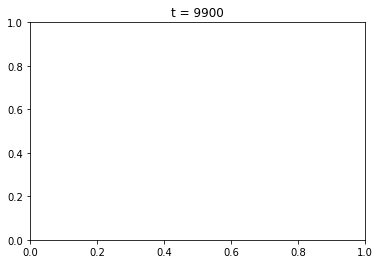

In [12]:
# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = 0,xmax = 126,ymin = 0, ymax = 20)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,NQLL[n,].shape[0]),NTot[n,])
    lineList[1][0].set_data(np.arange(0,NQLL[n,].shape[0]),NTot[n,]-NQLL[n,])
    plt.title('t = '+str(round(out.t[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(out.t))

plt.close()
HTML(anim.to_jshtml())

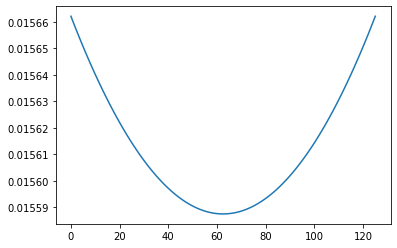

In [49]:
plt.figure()
plt.plot(depsurf)

In [16]:
tlast


31647.205701588016

In [17]:
tlast/deltaT

33055.00000001746

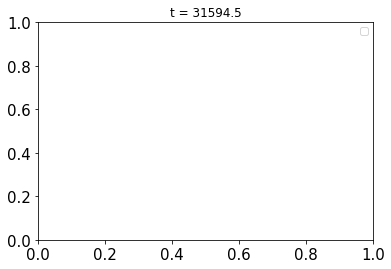

In [18]:


# make animation of the Fourier frequency spectrum over time
Ntotanim = Ntotkeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = 0,xmax = 250,ymin = -20, ymax = 10)
    
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Ntotanim[n])[0:256])))
    lineList[1][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Fliqanim[n])[0:256])))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

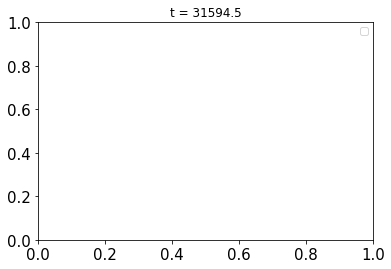

In [19]:
# animation of facet depth over time

Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

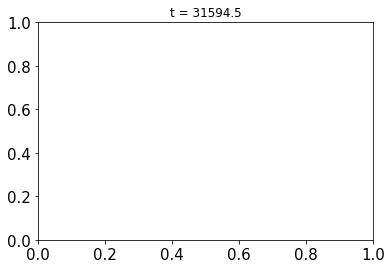

In [20]:
Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

maxK = 64
maxInd = np.shape(Niceanim[0])[0]
step = int(512/(2*maxK))
indices = np.concatenate([np.arange(0,maxK),np.arange(maxInd-maxK,maxInd)])

xred = np.linspace(0, xmax, maxK*2)

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[],[],[]) for i in range(4)]

legendList = ["Total Depth","Total Depth (Fourier)","QLL Depth","QLL Depth (Fourier)"]

# define function to draw each frame
def makeFrame(n):
    NiceFreq = np.fft.fft(Niceanim[n])/(512)
    NiceFreqTrunc = NiceFreq[indices]
    Nice2 = np.real(np.fft.ifft(NiceFreqTrunc)*(2*maxK))
    
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(xred-xmid,Nice2-min(Nice2))
    
    FliqFreq = np.fft.fft(Fliqanim[n])/(512)
    FliqFreqTrunc = FliqFreq[indices]
    Fliq2 = np.real(np.fft.ifft(FliqFreqTrunc)*(2*maxK))
    
    lineList[2][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    lineList[3][0].set_data(xred-xmid,Fliq2+Nice2-min(Nice2))
    plt.title('t = '+str(round(tanim[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

In [21]:
nu_kin

49

In [22]:
nQLL0 = fm.fftnorm(Fliqanim[0])[0:64]



In [23]:
k = np.arange(0,64)
sigmastepRed = sigmastep[0::4] # the 8 used to be 4 but this led tothe wrong size for sigmastepFFT breaking nTotRHS (128 instead of 64)

print(sigmastep.size)

#changed back to 4
sigmastep_FFT = fm.fftnorm(sigmastepRed)
fm.nTotRHS(nQLL0,nu_kin,sigmastep_FFT,k,D)

myN = np.concatenate((Ntot,[*Fliq,*Ntot][maxK:]))
params = {'N' : 64,
         'nu_kin' : nu_kin,
         'sigmastep' : sigmastepRed,
         'sigmastep_FFT' : sigmastep_FFT, # too long
         'k' : k,
         'D' : D,
         'ICNT' : Ntotanim[0],
         'ICNQLL' : Fliqanim[0],
         'endtime' : tanim[-1],
         'timesteps' : tanim,
         'counter' : 0,
         'Nstar' : Nstar}
q 
out = fm.runSim(params)

realSols = fm.makeReal(out.y)
nTotFourier = realSols[0]
nQLLFourier = realSols[1]

512


TypeError: nTotRHS() takes 4 positional arguments but 5 were given

In [ ]:
maxK = 64
xRed = np.linspace(0,50,maxK*2)

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = -25,xmax = 25,ymin = 0, ymax = 1000)
    
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,maxK),np.log(np.abs(out.y[0:maxK,n])))
    lineList[1][0].set_data(np.arange(0,maxK),np.log(np.abs())) #TODO: Jake do you know how to finish this? -max
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

In [ ]:
Fliqanim[0]

In [ ]:
np.zeros(2*64).shape